In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import random

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sns.set(font_scale=1, style='white')

In [2]:
class FixedModel(BaseEstimator):
    """
    sklearn model of the fixed model, 
    always allocating/predicting a fixed, pre-defined amount of resources.
    For use in sklearn functions like k-fold CV
    """
    def __init__(self, fixed_value):
        self.fixed_value = fixed_value
        
    def fit(self, X, y):
        """There's nothing to fit here"""
        return self
    
    def predict(self, X):
        """Always 'predict' the specified fixed value"""
        n_samples = X.shape[0]
        return [self.fixed_value for _ in range(n_samples)]

In [3]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [4]:
# Load data from path
web1 = pd.read_csv("vnf_data/csv_experiments_WEB1.csv")
web3 = pd.read_csv("vnf_data/csv_experiments_WEB3.csv")

# do processing, renaming and selection
mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "Max. throughput [kB/s]",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"
mapping01["param__func__de.upb.lb-nginx.0.1__mem_max"] = "Memory"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"
mapping03["param__func__de.upb.px-squid.0.1__mem_max"] = "Memory"

web1 = select_and_rename(web1, mapping01)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web3 = replaceSize(web3)

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [5]:
# select sub-datasets with small and large flows
# and with specific memory
mem = 128

web1_small = web1.loc[(web1["size"] == "small") & (web1["Memory"] == mem)]
web1_small = web1_small[["Max. throughput [kB/s]", "CPU"]]
web3_small = web3.loc[(web3["size"] == "small")  & (web3["Memory"] == mem)]
web3_small = web3_small[["Max. throughput [kB/s]", "CPU"]]

# add 20 "measurements" at 0 CPU and throuhgput
num_measures = 20
measures = [0 for _ in range(num_measures)]
web1_small = web1_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web3_small = web3_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)

In [6]:
def prepare_data(data):
    """Split return data"""
    X = data[['Max. throughput [kB/s]']]
    y = data['CPU']
    X = X.fillna(X.median())

    scaler = MinMaxScaler()
    scaler.fit_transform(X)
    
    return X, y

In [7]:
# prepare data
X_nginx, y_nginx = prepare_data(web1_small)
X_squid, y_squid = prepare_data(web3_small)

X_nginx.head()

,Max. throughput [kB/s]
0,516.81
1,493.60
2,519.22
3,514.01
4,518.83


In [8]:
def training_times(model, X, y, k=5):
    """Train the given model k times on the data and return training times"""
    times = []
    for _ in range(k):
        start = time.time()
        model.fit(X, y)
        end = time.time()
        times.append(end - start)
    return times

In [13]:
import statsmodels.stats.api as sms


def barplot(times, labels):
    assert len(times) == len(labels)
    
    times_mean = [t.mean() for t in times]
    print(times_mean)
    times_std = [t.std() for t in times]
    # 95% conf interval
#     times_conf = [sms.DescrStatsW(t).tconfint_mean()[1] for t in times]
    
    x = np.arange(len(labels))
    fig, ax = plt.subplots()
    plt.bar(x, times_mean, yerr=times_std, capsize=5)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Time [s]')

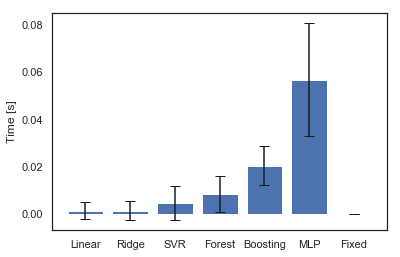

In [10]:
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP', 'Fixed']
models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), 
          GradientBoostingRegressor(), MLPRegressor(max_iter=1500), 
          FixedModel(fixed_value=0.8)]
train_times = np.array([training_times(models[i], X_nginx, y_nginx, k=30) for i in range(len(models))])

barplot(train_times, labels)

In [11]:
def prediction_times(model, X, k=100):
    """Predict y for given X with trained model. Repeat num_repetitions times and measure times"""   
    times = []
    for _ in range(k):
        start = time.time()
        y = model.predict(X)
        stop = time.time()
        times.append(stop - start)
    return times

[0.0009374213218688965, 0.0006250643730163574, 0.0004682803153991699, 0.001405942440032959, 0.00046872615814208985, 0.0004685521125793457, 0.0]


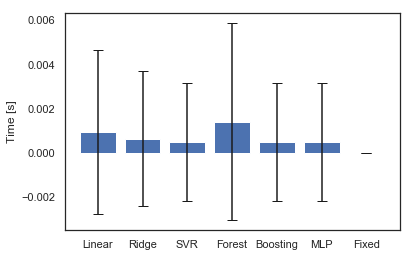

In [17]:
X_rand = pd.DataFrame(data={'Rand throughput': [random.randrange(0, 3000) for _ in range(1)]})
pred_times = np.array([prediction_times(models[i], X_rand, k=100) for i in range(len(models))])

barplot(pred_times, labels)